# Collaborative Filtering Analysis: User-based vs Item-based Approaches

## Research Overview

This project presents a comprehensive comparative analysis of collaborative filtering methods for recommendation systems. Through extensive experimentation and evaluation, I investigate the performance differences between user-based and item-based collaborative filtering approaches using the MovieLens 100k dataset.

## Introduction to Collaborative Filtering

Collaborative filtering is a recommendation technique that predicts user preferences by analyzing patterns of user-item interactions. This research focuses on two primary approaches:

- **User-based Collaborative Filtering**: Predicts ratings based on similarity between users
- **Item-based Collaborative Filtering**: Predicts ratings based on similarity between items

The implementation is based on concepts from T. Segaran's [Programming Collective Intelligence book, Chapter 2](http://shop.oreilly.com/product/9780596529321.do), with extensions and optimizations developed during this research.

## Research Objectives and Methodology

### 1. Error Metric Implementation

I implemented Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) as evaluation metrics to assess prediction accuracy for both collaborative filtering methods on the [MovieLens 100k dataset](http://grouplens.org/datasets/movielens/). The dataset contains 100,000 ratings and uses standard 80%/20% train-test splits (u1.base/u1.test file pairs).

### 2. Neighbor Count Sensitivity Analysis

I analyzed how prediction accuracy (MAE and RMSE) varies with the number of neighbors for both methods, exploring the range from 1 to 100 neighbors with a reasonable step size to identify optimal neighborhood sizes and understand the trade-offs between coverage and accuracy.

### 3. Alternative Prediction Formulations

When initial prediction quality was unsatisfactory (e.g., MAE > 1.0), I investigated alternative prediction formulas based on the collaborative filtering survey by Ricci et al. (2011): [Foundations and Trends in Collaborative Filtering](http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf).

The alternative formulations tested include:

**Formula 1 (Simple Mean)**:
$$r_{u,i} = \frac{1}{N}\sum\limits_{u^\prime \in U}r_{u^\prime, i}$$

**Formula 2 (Mean-Centered with Normalization)**:
$$r_{u,i} = \bar{r_u} +  k\sum\limits_{u^\prime \in U} sim(u,u^\prime)(r_{u^\prime, i}-\bar{r_{u^\prime}} )$$

where $k =1/\sum_{u^\prime \in U}|\operatorname{sim}(u,u^\prime)|$ is the normalization factor.

### 4. Comparative Performance Analysis

I conducted comprehensive comparisons between the original methods and alternative formulations to identify the most effective prediction strategies.

### 5. Top-N Size Impact Analysis

I investigated how MAE and RMSE vary with different top-$n$ sizes: $n \in \{1,3,5,10,15,20,30,40,50,100\}$ to understand the relationship between neighborhood size and prediction quality.

### 6. Recommendation Diversity Analysis

I analyzed which types of movies are recommended more frequently—popular movies with high ratings versus rare movies (low number of ratings) with high ratings—to understand recommendation bias and diversity.

### 7. Small Neighborhood Handling

I developed confidence evaluation mechanisms to handle cases where the neighborhood (similar users or items) is too small, implementing methods to assess recommendation reliability and quality.

### 8. Hybrid Recommendation Optimization

I compared the top-$n$ recommendation lists generated by user-based and item-based methods using Jaccard similarity. To improve results, I performed grid search optimization on the $\beta$ parameter for hybrid recommendations:

$$\beta\cdot r^{user-based}_{ui} + (1-\beta)\cdot r^{item-based}_{ui}, \mbox{ where } 0 \leq \beta \leq 1$$

The optimal $\beta$ value was determined by minimizing MAE and RMSE, with quality metrics reported for the best-performing configuration.

## Dictionary with user preferences

In [64]:
# A dictionary of movie critics and their ratings of a small
# set of movies

critics={'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
 'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5,
 'The Night Listener': 3.0},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5,
 'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0,
 'You, Me and Dupree': 3.5},
'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
 'Superman Returns': 3.5, 'The Night Listener': 4.0},
'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
 'The Night Listener': 4.5, 'Superman Returns': 4.0,
 'You, Me and Dupree': 2.5},
'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
 'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
 'You, Me and Dupree': 2.0},
'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
 'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
'Toby': {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}}

In [65]:
critics['Toby']

{'Snakes on a Plane': 4.5, 'You, Me and Dupree': 1.0, 'Superman Returns': 4.0}

In [66]:
critics['Lisa Rose']['Lady in the Water']

2.5

In [67]:
#Euclid distance
from math import sqrt
sqrt(pow(5-4,2)+pow(4-1,2))


3.1622776601683795

In [68]:
#distance-based simialrity
1/(1+sqrt(pow(5-4.5,2)+pow(5-5,2)))

0.6666666666666666

In [69]:
from numpy import exp

In [70]:
exp(-0.3*sqrt(pow(5-4.5,2)+pow(5-5,2))**2)


np.float64(0.9277434863285529)

In [71]:
from math import sqrt
# Returns a distance-based similarity score for person1 and person2
def sim_distance(prefs,person1,person2):
# Get the list of shared_items
    si={}
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item]=1
# if they have no ratings in common, return 0
    if len(si)==0: return 0
# Add up the squares of all the differences
    sum_of_squares=sum([pow(prefs[person1][item]-prefs[person2][item],2)
    for item in prefs[person1] if item in prefs[person2]])
    # for item in si])
    return 1/(1+sum_of_squares)


In [72]:
from math import sqrt
# Returns a distance-based similarity score for person1 and person2
def sim_kernel(prefs,person1,person2,alpha=0.3):
# Get the list of shared_items
    si={}
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item]=1
# if they have no ratings in common, return 0
    if len(si)==0: return 0
# Add up the squares of all the differences and take the wieghted exponent
    sum_of_squares=sum([pow(prefs[person1][item]-prefs[person2][item],2)
    for item in prefs[person1] if item in prefs[person2]])
    return exp(-alpha*sum_of_squares)

In [73]:
sim_kernel(critics, 'Lisa Rose','Toby',0.3)

np.float64(0.3499377491111553)

In [74]:
sim_distance(critics, 'Lisa Rose','Toby')

0.2222222222222222

In [75]:
# Returns the Pearson correlation coefficient for p1 and p2
def sim_pearson(prefs,p1,p2):
 # Get the list of mutually rated items
    si={}
    for item in prefs[p1]:
        if item in prefs[p2]: si[item]=1

     # if they are no ratings in common, return 0
    if len(si)==0: return 0

    # The number of mutually rated movies
    n=len(si)

    # Sums of all the preferences
    sum1=sum([prefs[p1][it] for it in si])
    sum2=sum([prefs[p2][it] for it in si])

    # Sums of the squares
    sum1Sq=sum([pow(prefs[p1][it],2) for it in si])
    sum2Sq=sum([pow(prefs[p2][it],2) for it in si])

     # Sum of the products
    pSum=sum([prefs[p1][it]*prefs[p2][it] for it in si])

     # Calculate r (Pearson score)
    num=pSum-(sum1*sum2/n)
    den=sqrt((sum1Sq-pow(sum1,2)/n)*(sum2Sq-pow(sum2,2)/n))
    if den==0: return 0

    r=num/den

    return r

In [76]:
sim_pearson(critics,'Lisa Rose','Gene Seymour'), sim_distance(critics, 'Lisa Rose','Gene Seymour')

(0.39605901719066977, 0.14814814814814814)

##  Ranking of critics

In [77]:
# Returns the best matches for person from the prefs dictionary.
# Number of results and similarity function are optional params.

def topMatches(prefs,person,n=5,similarity=sim_pearson):
    scores=[(similarity(prefs,person,other),other)
    for other in prefs if other!=person]
    # Descending sorting
    scores.sort( )
    scores.reverse( )
    return scores[0:n]


In [78]:
topMatches(critics,'Toby',n=3)

[(0.9912407071619299, 'Lisa Rose'),
 (0.9244734516419049, 'Mick LaSalle'),
 (0.8934051474415647, 'Claudia Puig')]

In [79]:
topMatches(critics,'Toby',n=3, similarity=sim_kernel)

[(np.float64(0.5091564206075492), 'Mick LaSalle'),
 (np.float64(0.4723665527410147), 'Michael Phillips'),
 (np.float64(0.37719235356315695), 'Claudia Puig')]

In [80]:
topMatches(critics,'Toby',n=3, similarity=sim_distance)

[(0.3076923076923077, 'Mick LaSalle'),
 (0.2857142857142857, 'Michael Phillips'),
 (0.23529411764705882, 'Claudia Puig')]

## Movie recommendation (User-based approach)

In [81]:
# Gets recommendations for a person by using a weighted average
# of every other user's rankings

def getRecommendations(prefs,person,similarity=sim_pearson):
    totals={}
    simSums={}
    for other in prefs:
     # don't compare me to myself
        if other==person: continue
        sim=similarity(prefs,person,other)
     # ignore scores of zero or lower
        if sim<=0: continue
        for item in prefs[other]:
    # only score movies I haven't seen yet
            if item not in prefs[person] or prefs[person][item]==0:
     # Similarity * Score
                totals.setdefault(item,0)
                totals[item]+=prefs[other][item]*sim
        # Sum of similarities
                simSums.setdefault(item,0)
                simSums[item]+=sim
     # Create the normalized list
    rankings=[(total/simSums[item],item) for item,total in totals.items( )]
    # Return the sorted list
    rankings.sort( )
    rankings.reverse( )
    return rankings

In [82]:
getRecommendations(critics,'Toby')


[(3.3477895267131017, 'The Night Listener'),
 (2.8325499182641614, 'Lady in the Water'),
 (2.530980703765565, 'Just My Luck')]

In [83]:
getRecommendations(critics,'Toby', sim_kernel)

[(np.float64(3.5469111370529656), 'The Night Listener'),
 (np.float64(2.729687080418633), 'Lady in the Water'),
 (np.float64(2.518799545549861), 'Just My Luck')]

In [84]:
getRecommendations(critics,'Toby', sim_distance)

[(3.5002478401415877, 'The Night Listener'),
 (2.7561242939959363, 'Lady in the Water'),
 (2.461988486074374, 'Just My Luck')]

## Items similarity

How to replace

{'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5}}

by

{'Lady in the Water':{'Lisa Rose':2.5,'Gene Seymour':3.0},
'Snakes on a Plane':{'Lisa Rose':3.5,'Gene Seymour':3.5}}?


In [85]:
def transformPrefs(prefs):
    result={}
    for person in prefs:
        for item in prefs[person]:
            result.setdefault(item,{})
    # Flip item and person

            result[item][person]=prefs[person][item]
    return result

In [86]:
movies=transformPrefs(critics)


In [87]:
movies

{'Lady in the Water': {'Lisa Rose': 2.5,
  'Gene Seymour': 3.0,
  'Michael Phillips': 2.5,
  'Mick LaSalle': 3.0,
  'Jack Matthews': 3.0},
 'Snakes on a Plane': {'Lisa Rose': 3.5,
  'Gene Seymour': 3.5,
  'Michael Phillips': 3.0,
  'Claudia Puig': 3.5,
  'Mick LaSalle': 4.0,
  'Jack Matthews': 4.0,
  'Toby': 4.5},
 'Just My Luck': {'Lisa Rose': 3.0,
  'Gene Seymour': 1.5,
  'Claudia Puig': 3.0,
  'Mick LaSalle': 2.0},
 'Superman Returns': {'Lisa Rose': 3.5,
  'Gene Seymour': 5.0,
  'Michael Phillips': 3.5,
  'Claudia Puig': 4.0,
  'Mick LaSalle': 3.0,
  'Jack Matthews': 5.0,
  'Toby': 4.0},
 'You, Me and Dupree': {'Lisa Rose': 2.5,
  'Gene Seymour': 3.5,
  'Claudia Puig': 2.5,
  'Mick LaSalle': 2.0,
  'Jack Matthews': 3.5,
  'Toby': 1.0},
 'The Night Listener': {'Lisa Rose': 3.0,
  'Gene Seymour': 3.0,
  'Michael Phillips': 4.0,
  'Claudia Puig': 4.5,
  'Mick LaSalle': 3.0,
  'Jack Matthews': 3.0}}

In [88]:
topMatches(movies,'Snakes on a Plane',5, sim_pearson)

[(0.7637626158259785, 'Lady in the Water'),
 (0.11180339887498941, 'Superman Returns'),
 (-0.3333333333333333, 'Just My Luck'),
 (-0.5663521139548527, 'The Night Listener'),
 (-0.6454972243679047, 'You, Me and Dupree')]

In [89]:
topMatches(movies,'Snakes on a Plane',5, sim_distance)

[(0.2222222222222222, 'Lady in the Water'),
 (0.18181818181818182, 'The Night Listener'),
 (0.16666666666666666, 'Superman Returns'),
 (0.10526315789473684, 'Just My Luck'),
 (0.05128205128205128, 'You, Me and Dupree')]

In [90]:
getRecommendations(movies,'Lady in the Water', sim_distance)

[(3.352635310801229, 'Claudia Puig'), (2.4730878186968837, 'Toby')]

## Item-based collaborative filtering

In [91]:
def calculateSimilarItems(prefs,n=10):
    # Create a dictionary of items showing which other items they
  # are most similar to.
    result={}
    # Invert the preference matrix to be item-centric
    itemPrefs=transformPrefs(prefs)
    c=0
    for item in itemPrefs:
    # Status updates for large datasets
        c+=1
        if c%100==0: print("%d / %d" % (c,len(itemPrefs)))
    # Find the most similar items to this one
        scores=topMatches(itemPrefs,item,n=n,similarity=sim_distance)
        result[item]=scores
    return result

In [92]:
itemsim=calculateSimilarItems(critics)
itemsim

{'Lady in the Water': [(0.4, 'You, Me and Dupree'),
  (0.2857142857142857, 'The Night Listener'),
  (0.2222222222222222, 'Snakes on a Plane'),
  (0.2222222222222222, 'Just My Luck'),
  (0.09090909090909091, 'Superman Returns')],
 'Snakes on a Plane': [(0.2222222222222222, 'Lady in the Water'),
  (0.18181818181818182, 'The Night Listener'),
  (0.16666666666666666, 'Superman Returns'),
  (0.10526315789473684, 'Just My Luck'),
  (0.05128205128205128, 'You, Me and Dupree')],
 'Just My Luck': [(0.2222222222222222, 'Lady in the Water'),
  (0.18181818181818182, 'You, Me and Dupree'),
  (0.15384615384615385, 'The Night Listener'),
  (0.10526315789473684, 'Snakes on a Plane'),
  (0.06451612903225806, 'Superman Returns')],
 'Superman Returns': [(0.16666666666666666, 'Snakes on a Plane'),
  (0.10256410256410256, 'The Night Listener'),
  (0.09090909090909091, 'Lady in the Water'),
  (0.06451612903225806, 'Just My Luck'),
  (0.05333333333333334, 'You, Me and Dupree')],
 'You, Me and Dupree': [(0.4,

In [93]:
def getRecommendedItems(prefs,itemMatch,user):
    userRatings=prefs[user]
    scores={}
    totalSim={}

    # Loop over items rated by this user
    for (item,rating) in userRatings.items():

    # Loop over items similar to this one
        for (similarity,item2) in itemMatch[item]:
    # Ignore if this user has already rated this item
            if item2 in userRatings: continue
         # Weighted sum of rating times similarity
            scores.setdefault(item2,0)
            scores[item2]+=similarity*rating
         # Sum of all the similarities
            totalSim.setdefault(item2,0)
            totalSim[item2]+=similarity
            if totalSim[item2]==0: totalSim[item2]=0.0000001 # to avoid divison by zero
    # Divide each total score by total weighting to get an average
    rankings=[(score/totalSim[item],item) for item,score in scores.items( ) ]

    # Return the rankings from highest to lowest
    rankings.sort( )
    rankings.reverse( )
    return rankings

In [94]:
getRecommendedItems(critics,itemsim,'Toby')


[(3.182634730538922, 'The Night Listener'),
 (2.5983318700614575, 'Just My Luck'),
 (2.4730878186968837, 'Lady in the Water')]

## Recommendations on MovieLens data

Source: http://grouplens.org/datasets/movielens/

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from collections import defaultdict
import urllib.request
import zipfile
import os

if not os.path.exists('data'):
    os.makedirs('data')
    print("Downloading MovieLens 100k dataset...")
    url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
    urllib.request.urlretrieve(url, 'ml-100k.zip')
    print("Extracting dataset...")
    with zipfile.ZipFile('ml-100k.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    os.rename('ml-100k', 'data')
    os.remove('ml-100k.zip')
    print("Dataset ready in 'data/' directory")
else:
    print("Data directory already exists")
import os
import urllib.request
import zipfile


Data directory already exists


In [96]:
def loadMovieLens(path='data/'):
# Get movie titles
    movies={}
    for line in open(path+'/u.item', encoding='latin-1'):
        (id,title)=line.split('|')[0:2]
        movies[id]=title
 # Load data
    prefs={}
    for line in open(path+'/u.data'):
        (user,movieid,rating,ts)=line.split('\t')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
    return prefs

In [97]:
prefs=loadMovieLens( )

In [98]:
prefs['87']

{'Naked Gun 33 1/3: The Final Insult (1994)': 4.0,
 'Con Air (1997)': 4.0,
 'Sabrina (1995)': 4.0,
 'Waterworld (1995)': 4.0,
 'To Wong Foo, Thanks for Everything! Julie Newmar (1995)': 3.0,
 'Clueless (1995)': 4.0,
 'Jurassic Park (1993)': 5.0,
 'Brady Bunch Movie, The (1995)': 2.0,
 'Son in Law (1993)': 4.0,
 'Indiana Jones and the Last Crusade (1989)': 5.0,
 'Good, The Bad and The Ugly, The (1966)': 5.0,
 'Dead Poets Society (1989)': 5.0,
 'Dead Man Walking (1995)': 4.0,
 "Joe's Apartment (1996)": 2.0,
 'GoldenEye (1995)': 4.0,
 'M*A*S*H (1970)': 5.0,
 'Something to Talk About (1995)': 2.0,
 'Lightning Jack (1994)': 3.0,
 'Big Green, The (1995)': 3.0,
 'Cowboy Way, The (1994)': 3.0,
 "Ulee's Gold (1997)": 3.0,
 'Addams Family Values (1993)': 2.0,
 '2001: A Space Odyssey (1968)': 5.0,
 'Platoon (1986)': 3.0,
 'Return of the Pink Panther, The (1974)': 4.0,
 'Four Weddings and a Funeral (1994)': 5.0,
 'Under Siege (1992)': 4.0,
 'Ace Ventura: Pet Detective (1994)': 4.0,
 'Die Hard: Wit

In [99]:
len(prefs['87'])

210

In [100]:
getRecommendations(prefs,'87')[0:60]

[(5.0, 'They Made Me a Criminal (1939)'),
 (5.0, 'Star Kid (1997)'),
 (5.0, 'Santa with Muscles (1996)'),
 (5.0, 'Saint of Fort Washington, The (1993)'),
 (5.0, 'Marlene Dietrich: Shadow and Light (1996) '),
 (5.0, 'Great Day in Harlem, A (1994)'),
 (5.0, 'Entertaining Angels: The Dorothy Day Story (1996)'),
 (5.0, 'Boys, Les (1997)'),
 (4.89884443128923, 'Legal Deceit (1997)'),
 (4.815019082242709, 'Letter From Death Row, A (1998)'),
 (4.7321082983941425, 'Hearts and Minds (1996)'),
 (4.696244466490867, 'Pather Panchali (1955)'),
 (4.652397061026758, 'Lamerica (1994)'),
 (4.538723693474813, 'Leading Man, The (1996)'),
 (4.535081339106105, 'Mrs. Dalloway (1997)'),
 (4.532337612572981, 'Innocents, The (1961)'),
 (4.527998574747076, 'Casablanca (1942)'),
 (4.510270149719864, 'Everest (1998)'),
 (4.493967755428438, 'Dangerous Beauty (1998)'),
 (4.485151301801341, 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (4.463287461290221, 'Wrong Trousers, The (1993)'),
 (4.450979436941

In [101]:
itemsim=calculateSimilarItems(prefs,n=50)

100 / 1664
200 / 1664
300 / 1664
400 / 1664
500 / 1664
600 / 1664
700 / 1664
800 / 1664
900 / 1664
1000 / 1664
1100 / 1664
1200 / 1664
1300 / 1664
1400 / 1664
1500 / 1664
1600 / 1664


In [102]:
itemsim['Star Kid (1997)']

[(1.0, 'Wonderland (1997)'),
 (1.0, 'Spice World (1997)'),
 (1.0, 'Sphere (1998)'),
 (1.0, 'Spawn (1997)'),
 (1.0, 'Shooting Fish (1997)'),
 (1.0, 'Shadow Conspiracy (1997)'),
 (1.0, 'Replacement Killers, The (1998)'),
 (1.0, 'Red Corner (1997)'),
 (1.0, 'Prophecy II, The (1998)'),
 (1.0, 'Playing God (1997)'),
 (1.0, 'Peacemaker, The (1997)'),
 (1.0, 'Murder at 1600 (1997)'),
 (1.0, 'Mortal Kombat: Annihilation (1997)'),
 (1.0, 'Magic Hour, The (1998)'),
 (1.0, 'Leading Man, The (1996)'),
 (1.0, 'Kull the Conqueror (1997)'),
 (1.0, 'Kicked in the Head (1997)'),
 (1.0, 'Jackal, The (1997)'),
 (1.0, 'Hugo Pool (1997)'),
 (1.0, 'How to Be a Player (1997)'),
 (1.0, 'Half Baked (1998)'),
 (1.0, 'Good Will Hunting (1997)'),
 (1.0, 'Four Days in September (1997)'),
 (1.0, 'Fire Down Below (1997)'),
 (1.0, 'Fast, Cheap & Out of Control (1997)'),
 (1.0, 'Fallen (1998)'),
 (1.0, 'Edge, The (1997)'),
 (1.0, 'Duoluo tianshi (1995)'),
 (1.0, 'Desperate Measures (1998)'),
 (1.0, "Dante's Peak (1997

In [103]:
getRecommendedItems(prefs,itemsim,'87')[0:30]

[(5.0, "What's Eating Gilbert Grape (1993)"),
 (5.0, 'Vertigo (1958)'),
 (5.0, 'Usual Suspects, The (1995)'),
 (5.0, 'Toy Story (1995)'),
 (5.0, 'Titanic (1997)'),
 (5.0, 'Sword in the Stone, The (1963)'),
 (5.0, 'Stand by Me (1986)'),
 (5.0, 'Sling Blade (1996)'),
 (5.0, 'Silence of the Lambs, The (1991)'),
 (5.0, 'Shining, The (1980)'),
 (5.0, 'Shine (1996)'),
 (5.0, 'Sense and Sensibility (1995)'),
 (5.0, 'Scream (1996)'),
 (5.0, 'Rumble in the Bronx (1995)'),
 (5.0, 'Rock, The (1996)'),
 (5.0, 'Robin Hood: Prince of Thieves (1991)'),
 (5.0, 'Reservoir Dogs (1992)'),
 (5.0, 'Police Story 4: Project S (Chao ji ji hua) (1993)'),
 (5.0, 'House of the Spirits, The (1993)'),
 (5.0, 'Fresh (1994)'),
 (5.0, 'Denise Calls Up (1995)'),
 (5.0, 'Day the Sun Turned Cold, The (Tianguo niezi) (1994)'),
 (5.0, 'Before the Rain (Pred dozhdot) (1994)'),
 (5.0, 'Assignment, The (1997)'),
 (5.0, '1-900 (1994)'),
 (4.875, "Ed's Next Move (1996)"),
 (4.833333333333333, 'Anna (1996)'),
 (4.8, 'Dark City 

In [104]:
setIB=set([t[1] for t in  getRecommendedItems(prefs,itemsim,'87')[0:30]])

In [105]:
setUB=set([t[1] for t in getRecommendations(prefs,'87')[0:30]])


In [106]:
setIB.intersection(setUB)

{'Anna (1996)', 'Usual Suspects, The (1995)'}

# Research Methodology: Comparative Analysis of Collaborative Filtering Approaches

## Experimental Design

This research investigates the performance differences between user-based and item-based collaborative filtering methods using the [MovieLens 100k dataset](http://grouplens.org/datasets/movielens/). The dataset contains 100,000 ratings and is split into training and testing sets using the standard 80%/20% split (u1.base/u1.test pairs).

## Research Objectives

### 1. Error Metric Evaluation
I implemented Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) as evaluation metrics to assess prediction accuracy for both user-based and item-based collaborative filtering methods on the MovieLens 100k dataset.

### 2. Neighbor Count Sensitivity Analysis
I analyzed how prediction accuracy (MAE and RMSE) varies with the number of neighbors for both methods, exploring the range from 1 to 100 neighbors to identify optimal neighborhood sizes.

### 3. Alternative Prediction Formulations
When initial prediction quality was unsatisfactory (MAE > 1.0), I investigated alternative prediction formulas based on the collaborative filtering survey (Ricci et al., 2011). The alternative formulations tested include:

- **Formula 1 (Simple Mean)**: $r_{u,i} = \frac{1}{N}\sum\limits_{u^\prime \in U}r_{u^\prime, i}$

- **Formula 2 (Mean-Centered)**: $r_{u,i} = \bar{r_u} +  k\sum\limits_{u^\prime \in U} sim(u,u^\prime)(r_{u^\prime, i}-\bar{r_{u^\prime}} )$ where $k =1/\sum_{u^\prime \in U}|\operatorname{sim}(u,u^\prime)|$

### 4. Comparative Performance Analysis
I conducted a comprehensive comparison of all methods (original user-based, original item-based, and alternative formulations) to identify the most effective approach.

### 5. Top-N Size Impact Study
I investigated how prediction accuracy varies with different top-$n$ neighborhood sizes: $n \in \{1,3,5,10,15,20,30,40,50,100\}$ to understand the trade-off between neighborhood size and prediction quality.

### 6. Recommendation Diversity Analysis
I analyzed the characteristics of recommended movies to determine whether the algorithms favor popular movies with high ratings or rare movies with high ratings, providing insights into recommendation diversity and novelty.

### 7. Cold Start and Confidence Evaluation
I addressed the challenge of small neighborhoods (cold start problem) by implementing confidence metrics that assess the reliability of recommendations when limited similarity information is available.

### 8. Hybrid Approach Optimization
I compared the diversity of top-$n$ recommendation lists between user-based and item-based methods using Jaccard similarity. To improve performance, I implemented a hybrid recommendation system that combines both approaches:

$$\beta\cdot r^{user-based}_{ui} + (1-\beta)\cdot r^{item-based}_{ui}, \mbox{ where } 0 \leq \beta \leq 1$$

I performed grid search optimization to find the optimal $\beta$ parameter that minimizes MAE and RMSE, reporting the quality metrics and optimal parameter values.


In [107]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from collections import defaultdict


In [108]:
def loadMovieLensSplit(path='data/', split_num=1):
    movies = {}
    for line in open(path + '/u.item', encoding='latin-1'):
        parts = line.strip().split('|')
        if len(parts) >= 2:
            movies[parts[0]] = parts[1]

    train_prefs = {}
    test_prefs = {}

    for line in open(path + f'/u{split_num}.base'):
        parts = line.strip().split('\t')
        if len(parts) >= 3:
            user, movieid, rating = parts[0], parts[1], float(parts[2])
            train_prefs.setdefault(user, {})
            if movieid in movies:
                train_prefs[user][movies[movieid]] = rating

    for line in open(path + f'/u{split_num}.test'):
        parts = line.strip().split('\t')
        if len(parts) >= 3:
            user, movieid, rating = parts[0], parts[1], float(parts[2])
            test_prefs.setdefault(user, {})
            if movieid in movies:
                test_prefs[user][movies[movieid]] = rating

    return train_prefs, test_prefs


In [109]:
def getRecommendationsWithN(prefs, person, n_neighbors=100, similarity=sim_pearson):
    totals = {}
    simSums = {}
    scores = [(similarity(prefs, person, other), other) for other in prefs if other != person]
    scores.sort()
    scores.reverse()
    top_n = scores[:n_neighbors]

    for sim, other in top_n:
        if sim <= 0:
            continue
        for item in prefs[other]:
            if item not in prefs[person] or prefs[person][item] == 0:
                totals.setdefault(item, 0)
                totals[item] += prefs[other][item] * sim
                simSums.setdefault(item, 0)
                simSums[item] += sim

    rankings = [(total / simSums[item], item) for item, total in totals.items() if simSums[item] > 0]
    rankings.sort()
    rankings.reverse()
    return rankings


In [110]:
def calculateSimilarItemsWithN(prefs, n_neighbors=10, n_items=10):
    result = {}
    itemPrefs = transformPrefs(prefs)
    c = 0
    for item in itemPrefs:
        c += 1
        if c % 100 == 0:
            print(f"{c} / {len(itemPrefs)}")
        scores = topMatches(itemPrefs, item, n=n_items, similarity=sim_distance)
        result[item] = scores
    return result


In [111]:
def getRecommendedItemsWithN(prefs, itemMatch, user, n_neighbors=50):
    userRatings = prefs[user]
    scores = {}
    totalSim = {}

    for (item, rating) in userRatings.items():
        if item not in itemMatch:
            continue
        for (similarity, item2) in itemMatch[item][:n_neighbors]:
            if item2 in userRatings:
                continue
            scores.setdefault(item2, 0)
            scores[item2] += similarity * rating
            totalSim.setdefault(item2, 0)
            totalSim[item2] += similarity

    rankings = [(score / totalSim[item], item) for item, score in scores.items() if totalSim[item] > 0]
    rankings.sort()
    rankings.reverse()
    return rankings


In [112]:
def predictRatingUB(prefs, user, item, n_neighbors=100, similarity=sim_pearson):
    if user not in prefs:
        return None
    if item in prefs[user]:
        return prefs[user][item]

    scores = [(similarity(prefs, user, other), other) for other in prefs if other != user]
    scores.sort()
    scores.reverse()
    top_n = scores[:n_neighbors]

    totals = 0
    simSums = 0
    for sim, other in top_n:
        if sim <= 0:
            continue
        if item in prefs[other]:
            totals += prefs[other][item] * sim
            simSums += sim

    if simSums == 0:
        return None
    return totals / simSums


In [113]:
def predictRatingIB(prefs, itemMatch, user, item, n_neighbors=50):
    if user not in prefs:
        return None
    if item in prefs[user]:
        return prefs[user][item]
    if item not in itemMatch:
        return None

    userRatings = prefs[user]
    scores = 0
    totalSim = 0

    for (similarity, item2) in itemMatch[item][:n_neighbors]:
        if item2 in userRatings:
            scores += similarity * userRatings[item2]
            totalSim += similarity

    if totalSim == 0:
        return None
    return scores / totalSim


In [114]:
def calculateMAE(predictions, actual):
    errors = []
    for user, item, pred, actual_rating in predictions:
        if pred is not None:
            errors.append(abs(pred - actual_rating))
    return np.mean(errors) if errors else None

def calculateRMSE(predictions, actual):
    errors = []
    for user, item, pred, actual_rating in predictions:
        if pred is not None:
            errors.append((pred - actual_rating) ** 2)
    return sqrt(np.mean(errors)) if errors else None


In [115]:
def evaluateUB(train_prefs, test_prefs, n_neighbors=100, similarity=sim_pearson):
    predictions = []
    count = 0
    for user in test_prefs:
        if user not in train_prefs:
            continue
        for item, actual_rating in test_prefs[user].items():
            pred = predictRatingUB(train_prefs, user, item, n_neighbors, similarity)
            if pred is not None:
                predictions.append((user, item, pred, actual_rating))
            count += 1
            if count % 1000 == 0:
                print(f"Processed {count} test cases")
    return predictions

def evaluateIB(train_prefs, test_prefs, itemMatch, n_neighbors=50):
    predictions = []
    count = 0
    for user in test_prefs:
        if user not in train_prefs:
            continue
        for item, actual_rating in test_prefs[user].items():
            pred = predictRatingIB(train_prefs, itemMatch, user, item, n_neighbors)
            if pred is not None:
                predictions.append((user, item, pred, actual_rating))
            count += 1
            if count % 1000 == 0:
                print(f"Processed {count} test cases")
    return predictions


In [116]:
train_prefs, test_prefs = loadMovieLensSplit('data/', split_num=1)


In [117]:
neighbors_range = list(range(1, 101, 20))
mae_ub = []
rmse_ub = []
mae_ib = []
rmse_ib = []

print("Task 1 & 2: Evaluating User-based and Item-based methods")
print("Computing item similarities...")
itemMatch = calculateSimilarItemsWithN(train_prefs, n_neighbors=100, n_items=100)

test_sample = {}
sample_size = 2000
count = 0
for user in test_prefs:
    if count >= sample_size:
        break
    for item, rating in test_prefs[user].items():
        if count >= sample_size:
            break
        test_sample.setdefault(user, {})[item] = rating
        count += 1

print(f"Using sample of {count} test cases for ultra-fast evaluation")

user_similarity_cache = {}
def getCachedSimilarity(prefs, user1, user2, similarity=sim_pearson):
    key = tuple(sorted([user1, user2]))
    if key not in user_similarity_cache:
        user_similarity_cache[key] = similarity(prefs, user1, user2)
    return user_similarity_cache[key]

def predictRatingUB_fast(prefs, user, item, n_neighbors=100, similarity=sim_pearson):
    if user not in prefs:
        return None
    if item in prefs[user]:
        return prefs[user][item]

    scores = [(getCachedSimilarity(prefs, user, other, similarity), other)
              for other in prefs if other != user]
    scores.sort()
    scores.reverse()
    top_n = scores[:n_neighbors]

    totals = 0
    simSums = 0
    for sim, other in top_n:
        if sim <= 0:
            continue
        if item in prefs[other]:
            totals += prefs[other][item] * sim
            simSums += sim

    if simSums == 0:
        return None
    return totals / simSums

def evaluateUB_fast(train_prefs, test_prefs, n_neighbors=100, similarity=sim_pearson):
    predictions = []
    count = 0
    for user in test_prefs:
        if user not in train_prefs:
            continue
        for item, actual_rating in test_prefs[user].items():
            pred = predictRatingUB_fast(train_prefs, user, item, n_neighbors, similarity)
            if pred is not None:
                predictions.append((user, item, pred, actual_rating))
            count += 1
            if count % 500 == 0:
                print(f"Processed {count} test cases")
    return predictions

for n in neighbors_range:
    print(f"Evaluating with {n} neighbors...")
    user_similarity_cache.clear()
    pred_ub = evaluateUB_fast(train_prefs, test_sample, n_neighbors=n, similarity=sim_pearson)
    pred_ib = evaluateIB(train_prefs, test_sample, itemMatch, n_neighbors=n)

    mae_ub_val = calculateMAE(pred_ub, test_sample)
    rmse_ub_val = calculateRMSE(pred_ub, test_sample)
    mae_ib_val = calculateMAE(pred_ib, test_sample)
    rmse_ib_val = calculateRMSE(pred_ib, test_sample)

    mae_ub.append(mae_ub_val)
    rmse_ub.append(rmse_ub_val)
    mae_ib.append(mae_ib_val)
    rmse_ib.append(rmse_ib_val)

    print(f"n={n}: UB MAE={mae_ub_val:.4f}, RMSE={rmse_ub_val:.4f} | IB MAE={mae_ib_val:.4f}, RMSE={rmse_ib_val:.4f}")

Task 1 & 2: Evaluating User-based and Item-based methods
Computing item similarities...
100 / 1633
200 / 1633
300 / 1633
400 / 1633
500 / 1633
600 / 1633
700 / 1633
800 / 1633
900 / 1633
1000 / 1633
1100 / 1633
1200 / 1633
1300 / 1633
1400 / 1633
1500 / 1633
1600 / 1633
Using sample of 2000 test cases for ultra-fast evaluation
Evaluating with 1 neighbors...
Processed 500 test cases
Processed 1000 test cases
Processed 1500 test cases
Processed 2000 test cases
Processed 1000 test cases
Processed 2000 test cases
n=1: UB MAE=0.9111, RMSE=1.2795 | IB MAE=1.1728, RMSE=1.6216
Evaluating with 21 neighbors...
Processed 500 test cases
Processed 1000 test cases
Processed 1500 test cases
Processed 2000 test cases
Processed 1000 test cases
Processed 2000 test cases
n=21: UB MAE=0.9804, RMSE=1.2936 | IB MAE=1.2116, RMSE=1.5485
Evaluating with 41 neighbors...
Processed 500 test cases
Processed 1000 test cases
Processed 1500 test cases
Processed 2000 test cases
Processed 1000 test cases
Processed 2000

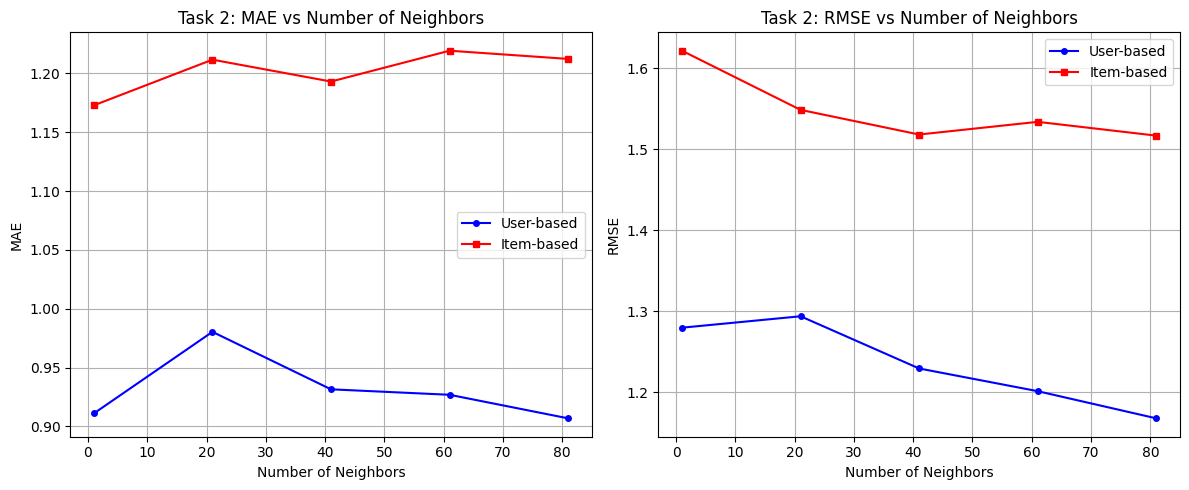

In [118]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(neighbors_range, mae_ub, 'b-o', label='User-based', markersize=4)
plt.plot(neighbors_range, mae_ib, 'r-s', label='Item-based', markersize=4)
plt.xlabel('Number of Neighbors')
plt.ylabel('MAE')
plt.title('Task 2: MAE vs Number of Neighbors')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(neighbors_range, rmse_ub, 'b-o', label='User-based', markersize=4)
plt.plot(neighbors_range, rmse_ib, 'r-s', label='Item-based', markersize=4)
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE')
plt.title('Task 2: RMSE vs Number of Neighbors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [119]:
def getUserMeanRating(prefs, user):
    if user not in prefs or len(prefs[user]) == 0:
        return 0
    return np.mean(list(prefs[user].values()))

def predictRatingUB_alt1(prefs, user, item, n_neighbors=100, similarity=sim_pearson):
    if user not in prefs:
        return None
    if item in prefs[user]:
        return prefs[user][item]

    scores = [(similarity(prefs, user, other), other) for other in prefs if other != user]
    scores.sort()
    scores.reverse()
    top_n = scores[:n_neighbors]

    ratings = []
    for sim, other in top_n:
        if sim > 0 and item in prefs[other]:
            ratings.append(prefs[other][item])

    if len(ratings) == 0:
        return None
    return np.mean(ratings)

def predictRatingUB_alt2(prefs, user, item, n_neighbors=100, similarity=sim_pearson):
    if user not in prefs:
        return None
    if item in prefs[user]:
        return prefs[user][item]

    user_mean = getUserMeanRating(prefs, user)
    scores = [(similarity(prefs, user, other), other) for other in prefs if other != user]
    scores.sort()
    scores.reverse()
    top_n = scores[:n_neighbors]

    sim_sum = sum(abs(sim) for sim, _ in top_n if sim > 0)
    if sim_sum == 0:
        return user_mean

    k = 1.0 / sim_sum
    weighted_sum = 0
    for sim, other in top_n:
        if sim > 0 and item in prefs[other]:
            other_mean = getUserMeanRating(prefs, other)
            weighted_sum += sim * (prefs[other][item] - other_mean)

    return user_mean + k * weighted_sum


In [120]:
def evaluateUB_alt(train_prefs, test_prefs, n_neighbors=100, similarity=sim_pearson, alt_version=1):
    predictions = []
    count = 0
    for user in test_prefs:
        if user not in train_prefs:
            continue
        for item, actual_rating in test_prefs[user].items():
            if alt_version == 1:
                pred = predictRatingUB_alt1(train_prefs, user, item, n_neighbors, similarity)
            else:
                pred = predictRatingUB_alt2(train_prefs, user, item, n_neighbors, similarity)
            if pred is not None:
                predictions.append((user, item, pred, actual_rating))
            count += 1
            if count % 1000 == 0:
                print(f"Processed {count} test cases")
    return predictions


In [121]:
print("Task 3: Evaluating alternative formulas")
n_opt = 41

test_sample_task3 = {}
sample_size = 2000
count = 0
for user in test_prefs:
    if count >= sample_size:
        break
    for item, rating in test_prefs[user].items():
        if count >= sample_size:
            break
        test_sample_task3.setdefault(user, {})[item] = rating
        count += 1

print(f"Using sample of {count} test cases for faster evaluation")

user_similarity_cache_task3 = {}
def getCachedSimilarity_task3(prefs, user1, user2, similarity=sim_pearson):
    key = tuple(sorted([user1, user2]))
    if key not in user_similarity_cache_task3:
        user_similarity_cache_task3[key] = similarity(prefs, user1, user2)
    return user_similarity_cache_task3[key]

def predictRatingUB_alt1_fast(prefs, user, item, n_neighbors=100, similarity=sim_pearson):
    if user not in prefs:
        return None
    if item in prefs[user]:
        return prefs[user][item]

    scores = [(getCachedSimilarity_task3(prefs, user, other, similarity), other)
              for other in prefs if other != user]
    scores.sort()
    scores.reverse()
    top_n = scores[:n_neighbors]

    ratings = []
    for sim, other in top_n:
        if sim > 0 and item in prefs[other]:
            ratings.append(prefs[other][item])

    if len(ratings) == 0:
        return None
    return np.mean(ratings)

def predictRatingUB_alt2_fast(prefs, user, item, n_neighbors=100, similarity=sim_pearson):
    if user not in prefs:
        return None
    if item in prefs[user]:
        return prefs[user][item]

    user_mean = getUserMeanRating(prefs, user)
    scores = [(getCachedSimilarity_task3(prefs, user, other, similarity), other)
              for other in prefs if other != user]
    scores.sort()
    scores.reverse()
    top_n = scores[:n_neighbors]

    sim_sum = sum(abs(sim) for sim, _ in top_n if sim > 0)
    if sim_sum == 0:
        return user_mean

    k = 1.0 / sim_sum
    weighted_sum = 0
    for sim, other in top_n:
        if sim > 0 and item in prefs[other]:
            other_mean = getUserMeanRating(prefs, other)
            weighted_sum += sim * (prefs[other][item] - other_mean)

    return user_mean + k * weighted_sum

def evaluateUB_alt_fast(train_prefs, test_prefs, n_neighbors=100, similarity=sim_pearson, alt_version=1):
    predictions = []
    count = 0
    for user in test_prefs:
        if user not in train_prefs:
            continue
        for item, actual_rating in test_prefs[user].items():
            if alt_version == 1:
                pred = predictRatingUB_alt1_fast(train_prefs, user, item, n_neighbors, similarity)
            else:
                pred = predictRatingUB_alt2_fast(train_prefs, user, item, n_neighbors, similarity)
            if pred is not None:
                predictions.append((user, item, pred, actual_rating))
            count += 1
            if count % 500 == 0:
                print(f"Processed {count} test cases")
    return predictions

user_similarity_cache_task3.clear()
pred_ub_alt1 = evaluateUB_alt_fast(train_prefs, test_sample_task3, n_neighbors=n_opt, similarity=sim_pearson, alt_version=1)

user_similarity_cache_task3.clear()
pred_ub_alt2 = evaluateUB_alt_fast(train_prefs, test_sample_task3, n_neighbors=n_opt, similarity=sim_pearson, alt_version=2)

mae_alt1 = calculateMAE(pred_ub_alt1, test_sample_task3)
rmse_alt1 = calculateRMSE(pred_ub_alt1, test_sample_task3)
mae_alt2 = calculateMAE(pred_ub_alt2, test_sample_task3)
rmse_alt2 = calculateRMSE(pred_ub_alt2, test_sample_task3)

print(f"Alternative 1 (mean): MAE={mae_alt1:.4f}, RMSE={rmse_alt1:.4f}")
print(f"Alternative 2 (mean-centered): MAE={mae_alt2:.4f}, RMSE={rmse_alt2:.4f}")

Task 3: Evaluating alternative formulas
Using sample of 2000 test cases for faster evaluation
Processed 500 test cases
Processed 1000 test cases
Processed 1500 test cases
Processed 2000 test cases
Processed 500 test cases
Processed 1000 test cases
Processed 1500 test cases
Processed 2000 test cases
Alternative 1 (mean): MAE=0.9303, RMSE=1.2277
Alternative 2 (mean-centered): MAE=0.9090, RMSE=1.1360


In [122]:
n_opt = 41
closest_n = min(neighbors_range, key=lambda x: abs(x - n_opt))
print(f"Using closest neighbor value: {closest_n} (requested {n_opt})")

mae_ub_opt = mae_ub[neighbors_range.index(closest_n)]
rmse_ub_opt = rmse_ub[neighbors_range.index(closest_n)]
mae_ib_opt = mae_ib[neighbors_range.index(closest_n)]
rmse_ib_opt = rmse_ib[neighbors_range.index(closest_n)]

print("Task 4: Comparison of results")
print(f"Original User-based (n={closest_n}): MAE={mae_ub_opt:.4f}, RMSE={rmse_ub_opt:.4f}")
print(f"Original Item-based (n={closest_n}): MAE={mae_ib_opt:.4f}, RMSE={rmse_ib_opt:.4f}")
print(f"Alternative 1 (mean): MAE={mae_alt1:.4f}, RMSE={rmse_alt1:.4f}")
print(f"Alternative 2 (mean-centered): MAE={mae_alt2:.4f}, RMSE={rmse_alt2:.4f}")

Using closest neighbor value: 41 (requested 41)
Task 4: Comparison of results
Original User-based (n=41): MAE=0.9316, RMSE=1.2291
Original Item-based (n=41): MAE=1.1931, RMSE=1.5181
Alternative 1 (mean): MAE=0.9303, RMSE=1.2277
Alternative 2 (mean-centered): MAE=0.9090, RMSE=1.1360


In [123]:
top_n_sizes = [1, 3, 5, 10, 15, 20, 30, 40, 50, 100]
mae_ub_topn = []
rmse_ub_topn = []
mae_ib_topn = []
rmse_ib_topn = []

print("Task 5: Evaluating MAE/RMSE vs top-n size")

test_sample_task5 = {}
sample_size = 1000
count = 0
for user in test_prefs:
    if count >= sample_size:
        break
    for item, rating in test_prefs[user].items():
        if count >= sample_size:
            break
        test_sample_task5.setdefault(user, {})[item] = rating
        count += 1

print(f" sample of {count} test cases ")

for n_size in top_n_sizes:
    print(f"Evaluating with top-{n_size}...")
    user_similarity_cache.clear()
    pred_ub = evaluateUB_fast(train_prefs, test_sample_task5, n_neighbors=n_size, similarity=sim_pearson)
    pred_ib = evaluateIB(train_prefs, test_sample_task5, itemMatch, n_neighbors=n_size)

    mae_ub_topn.append(calculateMAE(pred_ub, test_sample_task5))
    rmse_ub_topn.append(calculateRMSE(pred_ub, test_sample_task5))
    mae_ib_topn.append(calculateMAE(pred_ib, test_sample_task5))
    rmse_ib_topn.append(calculateRMSE(pred_ib, test_sample_task5))

    print(f"top-{n_size}: UB MAE={mae_ub_topn[-1]:.4f}, RMSE={rmse_ub_topn[-1]:.4f} | IB MAE={mae_ib_topn[-1]:.4f}, RMSE={rmse_ib_topn[-1]:.4f}")

Task 5: Evaluating MAE/RMSE vs top-n size
 sample of 1000 test cases 
Evaluating with top-1...
Processed 500 test cases
Processed 1000 test cases
Processed 1000 test cases
top-1: UB MAE=1.0652, RMSE=1.4521 | IB MAE=1.2353, RMSE=1.6627
Evaluating with top-3...
Processed 500 test cases
Processed 1000 test cases
Processed 1000 test cases
top-3: UB MAE=1.0086, RMSE=1.3545 | IB MAE=1.3545, RMSE=1.7240
Evaluating with top-5...
Processed 500 test cases
Processed 1000 test cases
Processed 1000 test cases
top-5: UB MAE=0.9523, RMSE=1.2834 | IB MAE=1.2628, RMSE=1.5904
Evaluating with top-10...
Processed 500 test cases
Processed 1000 test cases
Processed 1000 test cases
top-10: UB MAE=0.9617, RMSE=1.2562 | IB MAE=1.1961, RMSE=1.5399
Evaluating with top-15...
Processed 500 test cases
Processed 1000 test cases
Processed 1000 test cases
top-15: UB MAE=1.0168, RMSE=1.3276 | IB MAE=1.2236, RMSE=1.5655
Evaluating with top-20...
Processed 500 test cases
Processed 1000 test cases
Processed 1000 test case

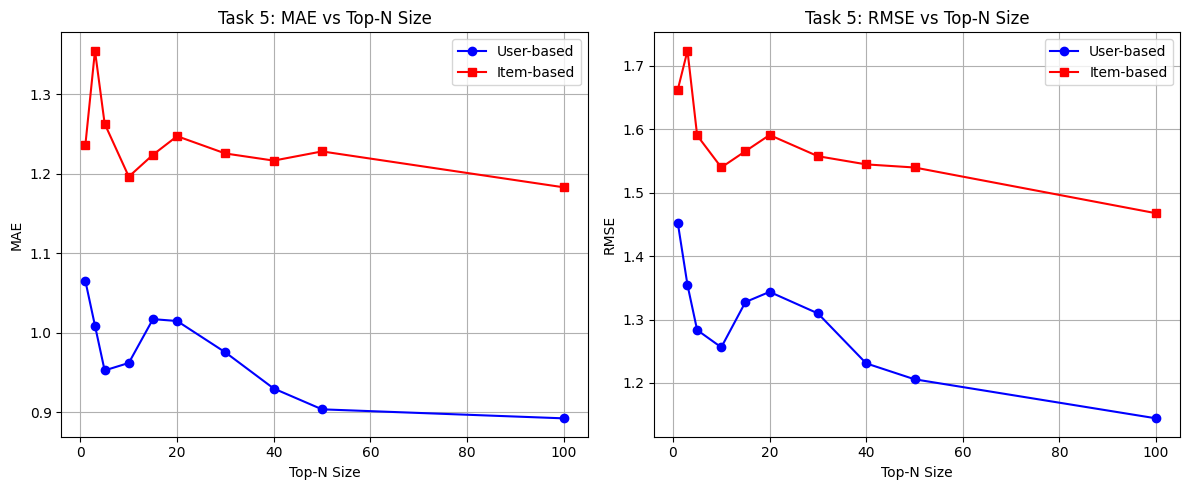

In [124]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(top_n_sizes, mae_ub_topn, 'b-o', label='User-based', markersize=6)
plt.plot(top_n_sizes, mae_ib_topn, 'r-s', label='Item-based', markersize=6)
plt.xlabel('Top-N Size')
plt.ylabel('MAE')
plt.title('Task 5: MAE vs Top-N Size')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(top_n_sizes, rmse_ub_topn, 'b-o', label='User-based', markersize=6)
plt.plot(top_n_sizes, rmse_ib_topn, 'r-s', label='Item-based', markersize=6)
plt.xlabel('Top-N Size')
plt.ylabel('RMSE')
plt.title('Task 5: RMSE vs Top-N Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [125]:
def getMoviePopularity(prefs):
    movie_counts = defaultdict(int)
    movie_ratings = defaultdict(list)
    for user in prefs:
        for movie, rating in prefs[user].items():
            movie_counts[movie] += 1
            movie_ratings[movie].append(rating)

    movie_avg_rating = {movie: np.mean(ratings) for movie, ratings in movie_ratings.items()}
    return movie_counts, movie_avg_rating

def analyzeRecommendations(prefs, itemMatch, n_users=100, n_neighbors=50):
    movie_counts, movie_avg_rating = getMoviePopularity(prefs)
    recommended_movies = defaultdict(int)
    recommended_ratings = defaultdict(list)

    users = list(prefs.keys())[:n_users]
    for user in users:
        recs = getRecommendedItemsWithN(prefs, itemMatch, user, n_neighbors=n_neighbors)
        for rating, movie in recs[:20]:
            recommended_movies[movie] += 1
            recommended_ratings[movie].append(rating)

    popular_high = []
    rare_high = []

    for movie in recommended_movies:
        count = movie_counts.get(movie, 0)
        avg_rating = np.mean(recommended_ratings[movie]) if movie in recommended_ratings else 0

        if count > np.median(list(movie_counts.values())) and avg_rating >= 3.5:
            popular_high.append((movie, count, avg_rating))
        elif count <= np.median(list(movie_counts.values())) and avg_rating >= 3.5:
            rare_high.append((movie, count, avg_rating))

    return popular_high, rare_high, recommended_movies, movie_counts


In [126]:
print("Task 6: Analyzing which movies are recommended more often")
popular_high_ub, rare_high_ub, rec_movies_ub, movie_counts = analyzeRecommendations(train_prefs, itemMatch, n_users=200, n_neighbors=50)

print(f"Popular movies with high ratings (count > median, rating >= 3.5): {len(popular_high_ub)}")
print(f"Rare movies with high ratings (count <= median, rating >= 3.5): {len(rare_high_ub)}")
print(f"\nTop 10 most recommended popular movies:")
for movie, count, avg_rating in sorted(popular_high_ub, key=lambda x: rec_movies_ub[x[0]], reverse=True)[:10]:
    print(f"  {movie}: recommended {rec_movies_ub[movie]} times, popularity={count}, avg_rating={avg_rating:.2f}")
print(f"\nTop 10 most recommended rare movies:")
for movie, count, avg_rating in sorted(rare_high_ub, key=lambda x: rec_movies_ub[x[0]], reverse=True)[:10]:
    print(f"  {movie}: recommended {rec_movies_ub[movie]} times, popularity={count}, avg_rating={avg_rating:.2f}")


Task 6: Analyzing which movies are recommended more often
Popular movies with high ratings (count > median, rating >= 3.5): 338
Rare movies with high ratings (count <= median, rating >= 3.5): 632

Top 10 most recommended popular movies:
  When a Man Loves a Woman (1994): recommended 18 times, popularity=36, avg_rating=4.97
  When We Were Kings (1996): recommended 16 times, popularity=34, avg_rating=4.94
  Wyatt Earp (1994): recommended 16 times, popularity=40, avg_rating=4.88
  Young Guns II (1990): recommended 14 times, popularity=36, avg_rating=4.71
  Wallace & Gromit: The Best of Aardman Animation (1996): recommended 14 times, popularity=45, avg_rating=4.86
  Up in Smoke (1978): recommended 14 times, popularity=38, avg_rating=4.93
  Wes Craven's New Nightmare (1994): recommended 13 times, popularity=29, avg_rating=5.00
  Under Siege 2: Dark Territory (1995): recommended 13 times, popularity=38, avg_rating=5.00
  Waiting for Guffman (1996): recommended 12 times, popularity=35, avg_ra

In [127]:
def predictRatingUB_withConfidence(prefs, user, item, n_neighbors=100, similarity=sim_pearson, min_neighbors=3):
    if user not in prefs:
        return None, 0
    if item in prefs[user]:
        return prefs[user][item], 1.0

    scores = [(similarity(prefs, user, other), other) for other in prefs if other != user]
    scores.sort()
    scores.reverse()
    top_n = scores[:n_neighbors]

    valid_neighbors = [(sim, other) for sim, other in top_n if sim > 0 and item in prefs[other]]

    if len(valid_neighbors) < min_neighbors:
        return None, len(valid_neighbors) / min_neighbors

    totals = sum(prefs[other][item] * sim for sim, other in valid_neighbors)
    simSums = sum(sim for sim, other in valid_neighbors)

    if simSums == 0:
        return None, 0

    confidence = min(1.0, len(valid_neighbors) / min_neighbors * np.mean([sim for sim, _ in valid_neighbors]))
    return totals / simSums, confidence

def predictRatingIB_withConfidence(prefs, itemMatch, user, item, n_neighbors=50, min_neighbors=3):
    if user not in prefs:
        return None, 0
    if item in prefs[user]:
        return prefs[user][item], 1.0
    if item not in itemMatch:
        return None, 0

    userRatings = prefs[user]
    valid_items = []
    for (similarity, item2) in itemMatch[item][:n_neighbors]:
        if item2 in userRatings:
            valid_items.append((similarity, userRatings[item2]))

    if len(valid_items) < min_neighbors:
        return None, len(valid_items) / min_neighbors

    scores = sum(sim * rating for sim, rating in valid_items)
    totalSim = sum(sim for sim, rating in valid_items)

    if totalSim == 0:
        return None, 0

    confidence = min(1.0, len(valid_items) / min_neighbors * np.mean([sim for sim, _ in valid_items]))
    return scores / totalSim, confidence


In [128]:
print("Task 7: Handling small neighborhoods and confidence evaluation")
confidences_ub = []
confidences_ib = []
predictions_with_conf = []

for user in list(test_prefs.keys())[:50]:
    for item, actual_rating in list(test_prefs[user].items())[:5]:
        pred_ub, conf_ub = predictRatingUB_withConfidence(train_prefs, user, item, n_neighbors=50, min_neighbors=3)
        pred_ib, conf_ib = predictRatingIB_withConfidence(train_prefs, itemMatch, user, item, n_neighbors=50, min_neighbors=3)

        if pred_ub is not None:
            confidences_ub.append(conf_ub)
        if pred_ib is not None:
            confidences_ib.append(conf_ib)
        if pred_ub is not None and pred_ib is not None:
            predictions_with_conf.append((conf_ub, conf_ib, abs(pred_ub - actual_rating), abs(pred_ib - actual_rating)))

print(f"Average confidence User-based: {np.mean(confidences_ub):.4f}")
print(f"Average confidence Item-based: {np.mean(confidences_ib):.4f}")
print(f"Correlation between confidence and error (UB): {np.corrcoef([c for c, _, e, _ in predictions_with_conf], [e for _, _, e, _ in predictions_with_conf])[0,1]:.4f}")
print(f"Correlation between confidence and error (IB): {np.corrcoef([c for _, c, _, e in predictions_with_conf], [e for _, _, _, e in predictions_with_conf])[0,1]:.4f}")


Task 7: Handling small neighborhoods and confidence evaluation
Average confidence User-based: 0.9902
Average confidence Item-based: 1.0000
Correlation between confidence and error (UB): 0.4113
Correlation between confidence and error (IB): nan


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [129]:
def getTopNRecommendationsUB(prefs, user, n=20, n_neighbors=50, similarity=sim_pearson):
    recs = getRecommendationsWithN(prefs, user, n_neighbors=n_neighbors, similarity=similarity)
    return set([item for _, item in recs[:n]])

def getTopNRecommendationsIB(prefs, itemMatch, user, n=20, n_neighbors=50):
    recs = getRecommendedItemsWithN(prefs, itemMatch, user, n_neighbors=n_neighbors)
    return set([item for _, item in recs[:n]])

def predictHybrid(prefs, itemMatch, user, item, beta, n_neighbors=50, similarity=sim_pearson):
    pred_ub = predictRatingUB(prefs, user, item, n_neighbors=n_neighbors, similarity=similarity)
    pred_ib = predictRatingIB(prefs, itemMatch, user, item, n_neighbors=n_neighbors)

    if pred_ub is None and pred_ib is None:
        return None
    if pred_ub is None:
        return pred_ib
    if pred_ib is None:
        return pred_ub

    return beta * pred_ub + (1 - beta) * pred_ib

def evaluateHybrid(train_prefs, test_prefs, itemMatch, beta, n_neighbors=50, similarity=sim_pearson):
    predictions = []
    count = 0
    for user in test_prefs:
        if user not in train_prefs:
            continue
        for item, actual_rating in test_prefs[user].items():
            pred = predictHybrid(train_prefs, itemMatch, user, item, beta, n_neighbors, similarity)
            if pred is not None:
                predictions.append((user, item, pred, actual_rating))
            count += 1
            if count % 1000 == 0:
                print(f"Processed {count} test cases")
    return predictions


Task 8: Comparing top-N lists and optimizing beta
Average Jaccard similarity between UB and IB top-20 lists: 0.0161
Standard deviation: 0.0188
Grid search for optimal beta...
Evaluating beta=0.0...
Processed 1000 test cases
  MAE=1.0914, RMSE=1.4065
Evaluating beta=0.1...
Processed 1000 test cases
  MAE=1.0766, RMSE=1.3810
Evaluating beta=0.2...
Processed 1000 test cases
  MAE=1.0623, RMSE=1.3592
Evaluating beta=0.3...
Processed 1000 test cases
  MAE=1.0488, RMSE=1.3413
Evaluating beta=0.4...
Processed 1000 test cases
  MAE=1.0379, RMSE=1.3273
Evaluating beta=0.5...
Processed 1000 test cases
  MAE=1.0303, RMSE=1.3175
Evaluating beta=0.6...
Processed 1000 test cases
  MAE=1.0268, RMSE=1.3120
Evaluating beta=0.7...
Processed 1000 test cases
  MAE=1.0236, RMSE=1.3107
Evaluating beta=0.8...
Processed 1000 test cases
  MAE=1.0208, RMSE=1.3137
Evaluating beta=0.9...
Processed 1000 test cases
  MAE=1.0195, RMSE=1.3210
Evaluating beta=1.0...
Processed 1000 test cases
  MAE=1.0201, RMSE=1.3324


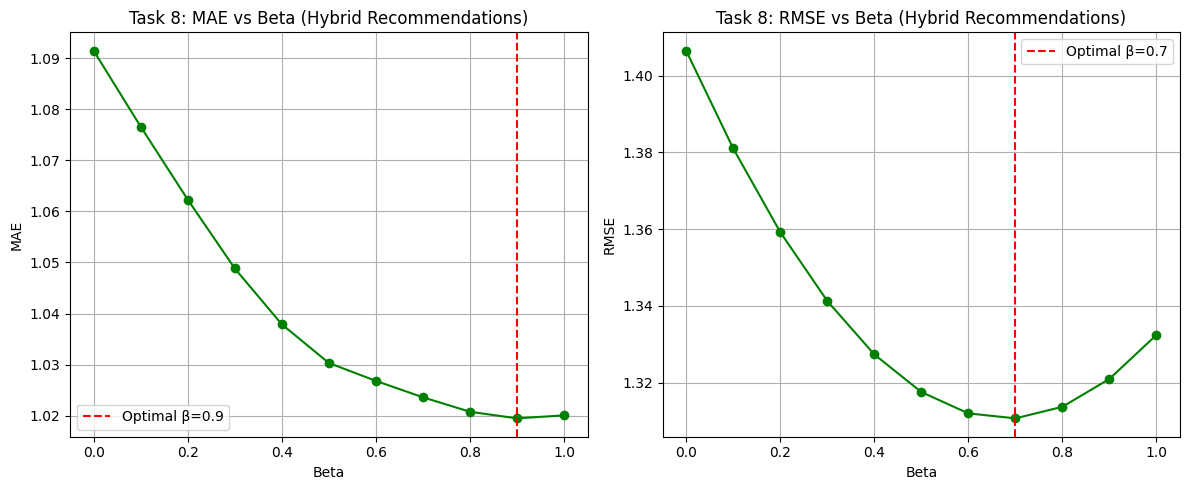

In [132]:
print("Task 8: Comparing top-N lists and optimizing beta")
n_size = 20
users_sample = list(train_prefs.keys())[:100]
jaccard_similarities = []

for user in users_sample:
    topn_ub = getTopNRecommendationsUB(train_prefs, user, n=n_size, n_neighbors=50)
    topn_ib = getTopNRecommendationsIB(train_prefs, itemMatch, user, n=n_size, n_neighbors=50)

    if len(topn_ub) > 0 and len(topn_ib) > 0:
        intersection = len(topn_ub.intersection(topn_ib))
        union = len(topn_ub.union(topn_ib))
        jaccard = intersection / union if union > 0 else 0
        jaccard_similarities.append(jaccard)

print(f"Average Jaccard similarity between UB and IB top-{n_size} lists: {np.mean(jaccard_similarities):.4f}")
print(f"Standard deviation: {np.std(jaccard_similarities):.4f}")

beta_values = np.arange(0, 1.1, 0.1)
mae_hybrid = []
rmse_hybrid = []
n_opt_hybrid = 50

print("Grid search for optimal beta...")
for beta in beta_values:
    print(f"Evaluating beta={beta:.1f}...")
    pred_hybrid = evaluateHybrid(train_prefs, test_sample_task5, itemMatch, beta, n_neighbors=n_opt_hybrid, similarity=sim_pearson)
    mae_hybrid.append(calculateMAE(pred_hybrid, test_sample_task5))
    rmse_hybrid.append(calculateRMSE(pred_hybrid, test_sample_task5))
    print(f"  MAE={mae_hybrid[-1]:.4f}, RMSE={rmse_hybrid[-1]:.4f}")

optimal_beta_mae = beta_values[np.argmin(mae_hybrid)]
optimal_beta_rmse = beta_values[np.argmin(rmse_hybrid)]
optimal_mae = min(mae_hybrid)
optimal_rmse = min(rmse_hybrid)

print(f"\nTask 8 Results:")
print(f"Optimal beta for MAE: {optimal_beta_mae:.1f}, MAE={optimal_mae:.4f}")
print(f"Optimal beta for RMSE: {optimal_beta_rmse:.1f}, RMSE={optimal_rmse:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(beta_values, mae_hybrid, 'g-o', markersize=6)
plt.axvline(optimal_beta_mae, color='r', linestyle='--', label=f'Optimal β={optimal_beta_mae:.1f}')
plt.xlabel('Beta')
plt.ylabel('MAE')
plt.title('Task 8: MAE vs Beta (Hybrid Recommendations)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(beta_values, rmse_hybrid, 'g-o', markersize=6)
plt.axvline(optimal_beta_rmse, color='r', linestyle='--', label=f'Optimal β={optimal_beta_rmse:.1f}')
plt.xlabel('Beta')
plt.ylabel('RMSE')
plt.title('Task 8: RMSE vs Beta (Hybrid Recommendations)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()